<a href="https://colab.research.google.com/github/quarcs-lab/pysalnarsc19/blob/master/content/420_rank_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Rank Mobility



## Introduction

This notebook introduces two classic nonparametric statistics of exchange mobility and their spatial extensions. We will demonstrate the usage of these methods by an empirical study for understanding [regional exchange mobility pattern in US](#Regional-exchange-mobility-pattern-in-US-1929-2009). The dataset is the per capita incomes observed annually from 1929 to 2009 for the lower 48 US states.


* Classic measures:
    * [Classic Kendall's $\tau$](#Classic-Kendall's-$\tau$)
    * [Local Kendall's $\tau$](#Local-Kendall's-$\tau$)
* Spatial extensions:
    * [Spatial Kendall's $\tau$](#Spatial-Kendall's-$\tau$)
    * [Inter- and Intra-regional decomposition of Kendall's $\tau$](#Inter--and-Intra-regional-decomposition-of-Kendall's-$\tau$)
    * [Local indicator of mobility association-LIMA](#Local-indicator-of-mobility-association-LIMA)


# Setup

## Install libraries

In [1]:
!pip install -q seaborn
!pip install -q geopandas
!pip install -q shapely
!pip install -q libpysal
!pip install -q mapclassify
!pip install -q splot
!pip install -q legendgram
!pip install -q esda
!pip install -q inequality
!pip install -q giddy

     |████████████████████████████████| 931kB 4.5MB/s 
     |████████████████████████████████| 10.4MB 12.7MB/s 
     |████████████████████████████████| 14.7MB 61.2MB/s 
     |████████████████████████████████| 2.4MB 5.1MB/s 
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 266kB 14.7MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 235kB 9.9MB/s 


## Load libraries

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import mapclassify
import legendgram
import splot
from splot.mapping import vba_choropleth
from splot._viz_utils import shift_colormap
import libpysal 
from libpysal import examples
from libpysal import io
from libpysal.weights import Queen, Rook, KNN, Kernel
import giddy
from giddy.markov import Markov
from giddy.directional import Rose


## Load data from Github 

In [3]:
# It will be cloned for about a 12 hours. That is, you have to re-run this code only after 12 hours
 !git clone --recursive https://github.com/quarcs-lab/pysalnarsc19.git

Cloning into 'pysalnarsc19'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 438 (delta 54), reused 32 (delta 14), pack-reused 318
Receiving objects: 100% (438/438), 76.34 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Checking out files: 100% (163/163), done.


In [4]:
# Let us see what we have inside content/data Folder
 !ls pysalnarsc19/content/data

airbnb.cpg			  neighborhoods.gpkg
airbnb.dbf			  neighbourhoods.geojson
airbnb.prj			  participants2016.csv
airbnb.shp			  participants2017.csv
airbnb.shx			  participants2018.csv
airports.csv			  README.md
b500.cpg			  riverside_city.dbf
b500.dbf			  riverside_city.prj
b500.prj			  riverside_city.qpj
b500.shp			  riverside_city.shp
b500.shx			  riverside_city.shx
behavioralHealth.dbf		  san_diego.cpg
behavioralHealth.prj		  san_diego.dbf
behavioralHealth.qpj		  san_diego.prj
behavioralHealth.shp		  san_diego.shp
behavioralHealth.shx		  san_diego.shx
CAINC1__ALL_STATES_1969_2017.csv  san_diego.tif
CAINC1__definition.xml		  sd_tracts_acs_clean.dbf
CAINC1__Footnotes.html		  sd_tracts_acs_clean.prj
california_tracts.cpg		  sd_tracts_acs_clean.qpj
california_tracts.dbf		  sd_tracts_acs_clean.shp
california_tracts.prj		  sd_tracts_acs_clean.shx
california_tracts.shp		  states48.gal
california_tracts.shx		  texas.dbf
city_tracts.cpg			  texas.geojson
city_tracts.dbf			  texas.prj
city_tracts

In [0]:
# Load data (from cloned repository)
# db = geopandas.read_file('pysalnarsc19/content/data/texas.shp')

## Regional exchange mobility pattern in US 1929-2009

Firstly we load in the US dataset:

In [5]:
geo_table = gpd.read_file(libpysal.examples.get_path('us48.shp'))
income_table = pd.read_csv(libpysal.examples.get_path("usjoin.csv"))
complete_table = geo_table.merge(income_table,left_on='STATE_NAME',right_on='Name')
complete_table.head()

,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS_x,SUB_REGION,STATE_ABBR,geometry,Name,STATE_FIPS_y,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,...,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,20.750,34.956,1,1,Washington,53,Pacific,WA,"MULTIPOLYGON (((-122.40075 48.22540, -122.4615...",Washington,53,741,658,534,402,376,443,490,569,599,582,614,658,864,1196,1469,1527,1419,1401,1504,1624,1595,1721,1874,1973,2066,2077,2116,2172,2262,...,4205,4381,4731,5312,5919,6533,7181,7832,8887,9965,10913,11903,12431,13124,14021,14738,15522,16300,17270,18670,20026,20901,21917,22414,23119,23878,25287,26817,28632,30392,31528,32053,32206,32934,34984,35738,38477,40782,41588,40619
1,45.132,34.527,2,2,Montana,30,Mtn,MT,"POLYGON ((-111.47463 44.70224, -111.48001 44.6...",Montana,30,592,501,382,339,298,364,476,475,512,517,533,569,713,901,1150,1183,1206,1308,1484,1642,1412,1654,1806,1823,1810,1771,1894,1929,1983,...,3625,3789,4355,5012,5380,5794,6200,6636,7721,8299,9143,10244,10672,11045,11705,11900,12465,12996,13362,14623,15524,16509,17114,18072,18129,18764,19383,20167,21324,22019,22569,24342,24699,25963,27517,28987,30942,32625,33293,32699
2,9.571,18.899,3,3,Maine,23,N Eng,ME,"MULTIPOLYGON (((-69.77779 44.07407, -69.86044 ...",Maine,23,601,576,491,377,371,416,430,506,510,471,495,526,631,857,1102,1102,1079,1134,1169,1240,1183,1195,1319,1438,1449,1448,1581,1669,1720,...,3423,3594,3864,4319,4764,5019,5708,6142,6751,7497,8408,9231,9873,10551,11665,12533,13463,14595,15813,16886,17479,17662,18350,18810,19531,20240,21293,22305,23529,24603,25623,27068,27731,28727,30201,30721,32340,33620,34906,35268
3,21.874,21.353,4,4,North Dakota,38,W N Cen,ND,"POLYGON ((-98.73006 45.93830, -99.00645 45.939...",North Dakota,38,382,311,187,176,146,180,272,234,326,282,319,355,529,665,966,1031,1046,1088,1494,1483,1211,1360,1444,1318,1336,1364,1490,1556,1598,...,3214,3669,4377,6172,6120,6334,6184,6427,8136,8398,8095,10342,10990,11386,12307,12811,13126,13565,12745,14357,15880,16270,17692,17830,19033,19084,21166,20798,22767,23313,25068,26118,26770,29109,29676,31644,32856,35882,39009,38672
4,22.598,22.746,5,5,South Dakota,46,W N Cen,SD,"POLYGON ((-102.78793 42.99532, -103.00541 42.9...",South Dakota,46,426,366,241,189,129,184,309,244,323,320,345,361,475,757,846,979,1086,1132,1270,1526,1116,1283,1497,1327,1436,1457,1342,1419,1669,...,3256,3538,4065,5163,5178,5667,5591,6351,7347,8158,8142,9451,9915,10195,11619,11942,12486,13217,13807,14767,16238,16961,17966,18565,19607,19848,21736,22275,23797,25045,26115,27531,27727,30072,31765,32726,33320,35998,38188,36499


We will visualize the spatial distributions of per capita incomes of US states across 1929 to 2009 to obtain a first impression of the dynamics. 

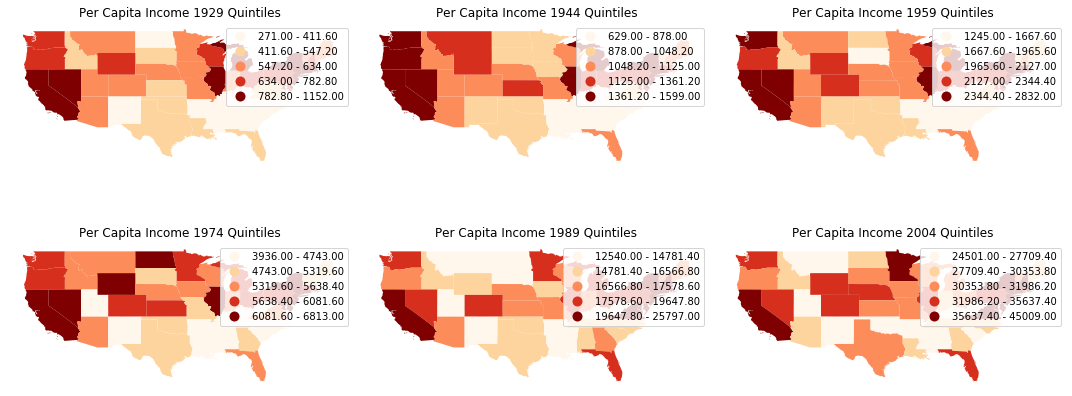

In [6]:
index_year = range(1929,2010,15)
fig, axes = plt.subplots(nrows=2, ncols=3,figsize = (15,7))
for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        complete_table.plot(ax=ax, column=str(index_year[i*3+j]), cmap='OrRd', scheme='quantiles', legend=True)
        ax.set_title('Per Capita Income %s Quintiles'%str(index_year[i*3+j]))
        ax.axis('off')
plt.tight_layout()

Text(0.5, 1.0, 'Relative per capita incomes of 48 US states')

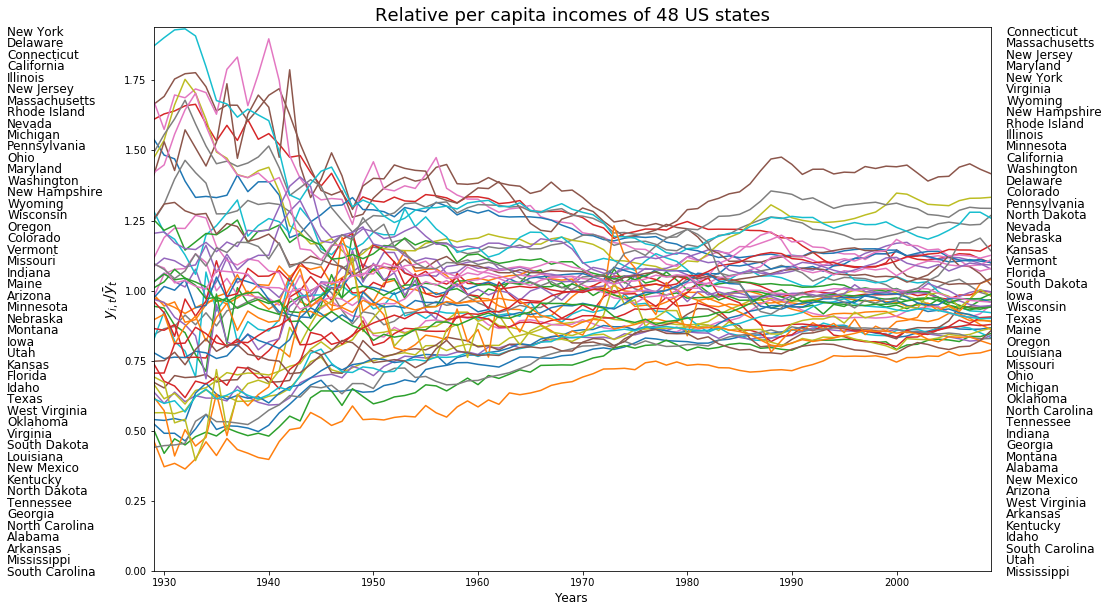

In [7]:
years = range(1929,2010)
names = income_table['Name']
pci = income_table.drop(['Name','STATE_FIPS'], 1).values.T
rpci= (pci.T / pci.mean(axis=1)).T
order1929 = np.argsort(rpci[0,:])
order2009 = np.argsort(rpci[-1,:])
names1929 = names[order1929[::-1]]
names2009 = names[order2009[::-1]]
first_last = np.vstack((names1929,names2009))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
p = plt.plot(years,rpci)
for i in range(48):
    plt.text(1915,1.91-(i*0.041), first_last[0][i],fontsize=12)
    plt.text(2010.5,1.91-(i*0.041), first_last[1][i],fontsize=12)
plt.xlim((years[0], years[-1]))
plt.ylim((0, 1.94))
plt.ylabel(r"$y_{i,t}/\bar{y}_t$",fontsize=14)
plt.xlabel('Years',fontsize=12)
plt.title('Relative per capita incomes of 48 US states',fontsize=18)

The above figure displays the trajectories of relative per capita incomes of 48 US states. It is quite obvious that states were swapping positions across 1929-2009. We will demonstrate how to quantify the exchange mobility as well as how to assess the regional and local contribution to the overall exchange mobility. We will ultilize [BEA regions](https://www.bea.gov/regional/docs/regions.cfm) and base on it for constructing the block weight matrix. 

BEA regional scheme divide US states into 8 regions:
* New England Region
* Mideast Region
* Great Lakes Region
* Plains Region
* Southeast Region
* Southwest Region
* Rocky Mountain Region
* Far West Region

As the dataset does not contain information regarding BEA regions, we manually input the regional information:

In [8]:
BEA_regions = ["New England Region","Mideast Region","Great Lakes Region","Plains Region","Southeast Region","Southwest Region","Rocky Mountain Region","Far West Region"]
BEA_regions_abbr = ["NENG","MEST","GLAK","PLNS","SEST","SWST","RKMT","FWST"]
BEA = pd.DataFrame({ 'Region code' : np.arange(1,9,1), 'BEA region' : BEA_regions,'BEA abbr':BEA_regions_abbr})
BEA

,Region code,BEA region,BEA abbr
0,1,New England Region,NENG
1,2,Mideast Region,MEST
2,3,Great Lakes Region,GLAK
3,4,Plains Region,PLNS
4,5,Southeast Region,SEST
5,6,Southwest Region,SWST
6,7,Rocky Mountain Region,RKMT
7,8,Far West Region,FWST


In [9]:
region_code = list(np.repeat(1,6))+list(np.repeat(2,6))+list(np.repeat(3,5))+list(np.repeat(4,7))+list(np.repeat(5,12))+list(np.repeat(6,4))+list(np.repeat(7,5))+list(np.repeat(8,6))
state_code = ['09','23','25','33','44','50','10','11','24','34','36','42','17','18','26','39','55','19','20','27','29','31','38','46','01','05','12','13','21','22','28','37','45','47','51','54','04','35','40','48','08','16','30','49','56','02','06','15','32','41','53']
state_region = pd.DataFrame({'Region code':region_code,"State code":state_code})
state_region_all = state_region.merge(BEA,left_on='Region code',right_on='Region code')
complete_table = complete_table.merge(state_region_all,left_on='STATE_FIPS_x',right_on='State code')
complete_table.head()

,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS_x,SUB_REGION,STATE_ABBR,geometry,Name,STATE_FIPS_y,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,...,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,Region code,State code,BEA region,BEA abbr
0,20.750,34.956,1,1,Washington,53,Pacific,WA,"MULTIPOLYGON (((-122.40075 48.22540, -122.4615...",Washington,53,741,658,534,402,376,443,490,569,599,582,614,658,864,1196,1469,1527,1419,1401,1504,1624,1595,1721,1874,1973,2066,2077,2116,2172,2262,...,5919,6533,7181,7832,8887,9965,10913,11903,12431,13124,14021,14738,15522,16300,17270,18670,20026,20901,21917,22414,23119,23878,25287,26817,28632,30392,31528,32053,32206,32934,34984,35738,38477,40782,41588,40619,8,53,Far West Region,FWST
1,45.132,34.527,2,2,Montana,30,Mtn,MT,"POLYGON ((-111.47463 44.70224, -111.48001 44.6...",Montana,30,592,501,382,339,298,364,476,475,512,517,533,569,713,901,1150,1183,1206,1308,1484,1642,1412,1654,1806,1823,1810,1771,1894,1929,1983,...,5380,5794,6200,6636,7721,8299,9143,10244,10672,11045,11705,11900,12465,12996,13362,14623,15524,16509,17114,18072,18129,18764,19383,20167,21324,22019,22569,24342,24699,25963,27517,28987,30942,32625,33293,32699,7,30,Rocky Mountain Region,RKMT
2,9.571,18.899,3,3,Maine,23,N Eng,ME,"MULTIPOLYGON (((-69.77779 44.07407, -69.86044 ...",Maine,23,601,576,491,377,371,416,430,506,510,471,495,526,631,857,1102,1102,1079,1134,1169,1240,1183,1195,1319,1438,1449,1448,1581,1669,1720,...,4764,5019,5708,6142,6751,7497,8408,9231,9873,10551,11665,12533,13463,14595,15813,16886,17479,17662,18350,18810,19531,20240,21293,22305,23529,24603,25623,27068,27731,28727,30201,30721,32340,33620,34906,35268,1,23,New England Region,NENG
3,21.874,21.353,4,4,North Dakota,38,W N Cen,ND,"POLYGON ((-98.73006 45.93830, -99.00645 45.939...",North Dakota,38,382,311,187,176,146,180,272,234,326,282,319,355,529,665,966,1031,1046,1088,1494,1483,1211,1360,1444,1318,1336,1364,1490,1556,1598,...,6120,6334,6184,6427,8136,8398,8095,10342,10990,11386,12307,12811,13126,13565,12745,14357,15880,16270,17692,17830,19033,19084,21166,20798,22767,23313,25068,26118,26770,29109,29676,31644,32856,35882,39009,38672,4,38,Plains Region,PLNS
4,22.598,22.746,5,5,South Dakota,46,W N Cen,SD,"POLYGON ((-102.78793 42.99532, -103.00541 42.9...",South Dakota,46,426,366,241,189,129,184,309,244,323,320,345,361,475,757,846,979,1086,1132,1270,1526,1116,1283,1497,1327,1436,1457,1342,1419,1669,...,5178,5667,5591,6351,7347,8158,8142,9451,9915,10195,11619,11942,12486,13217,13807,14767,16238,16961,17966,18565,19607,19848,21736,22275,23797,25045,26115,27531,27727,30072,31765,32726,33320,35998,38188,36499,4,46,Plains Region,PLNS


The BEA regions are visualized below:

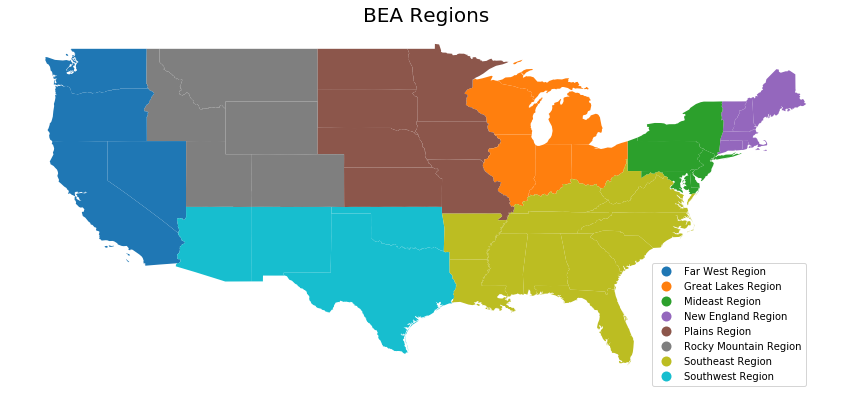

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (15,8))
beaplot = complete_table.plot(ax=ax,column="BEA region", legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.8, 0.15, 0.16, 0.2))
beaplot.set_title("BEA Regions",fontdict={"fontsize":20})
ax.set_axis_off()

## Kendall's $\tau$

Kendall’s $\tau$ statistic is based on a comparison of the number of pairs of $n$ observations that have concordant ranks between two variables. For measuring exchange mobility in **giddy**, the two variables in question are the values of an attribute measured at two points in time over $n$ spatial units. This classic measure of rank correlation indicates how much relative stability there has been in the map pattern over the two periods. Spatial decomposition of Kendall’s $\tau$ can be classified into three spatial scales: global spatial decomposition, inter- and intra-regional decomposition and local spatial decomposition. More details will be given latter.

### Classic Kendall's $\tau$

Kendall's $\tau$ statistic is a global measure of exchange mobility. For $n$ spatial units over two periods, it is formally defined as follows:

$$\tau = \frac{c-d}{(n(n-1))/2}$$

where $c$ is the number of concordant pairs  and $d$ is the number of discordant pairs. A pair $(i,j)$ is concordant if $(y_{i,t}-y_{j,t}) * (y_{i,t+1}-y_{j,t+1}) > 0$, and discordant if the signed product is negative.

By definition: $-1 \leq \tau \leq 1$. Negative values $\tau$ indicate higher exchange mobility, positive values point to lower exchange mobility.

In giddy, class $Tau$ requires two inputs: a cross-section of income values at one period ($x$) and a cross-section of income values at another period ($y$):

```python
giddy.rank.Tau(self, x, y)
```

We will construct a $Tau$ instance by specifying the incomes in two periods. Here, we look at the global exchange mobility of US states between 1929 and 2009.

In [11]:
tau = giddy.rank.Tau(complete_table["1929"],complete_table["2009"])
tau

In [12]:
tau.concordant

856.0

In [13]:
tau.discordant

271.0

There are 856 concordant pairs of US states between 1929 and 2009, and 271 discordant pairs.

In [14]:
tau.tau

0.5188470576690462

In [15]:
tau.tau_p

1.9735720263920198e-07

The observed Kendall's $\tau$ statistic is 0.519 and its p-value is $1.974 \times 10^{-7}$. Therefore, we will reject the null hypothesis of no assocation between 1929 and 2009 at the $5\%$ significance level.

### Spatial Kendall's $\tau$

The spatial Kendall's $\tau$ decomposes all pairs into those that are spatial neighbors and those that are not, and examines whether the rank correlation is different between the two sets (Rey, 2014). 

$$\tau_w = \frac{\iota'(W\circ S)\iota}{\iota'W \iota}$$

$W$ is the binary spatial weight matrix, $S$ is the concordance matrix and $\iota$ is the $(n,1)$ unity vector. The null hypothesis is the spatial randomness of rank exchanges. Inference on $\tau_w$ is based on random spatial permutation of incomes at two periods. 

```python
giddy.rank.SpatialTau(self, x, y, w, permutations=0)
```
For illustration, we turn back to the case of incomes in US states over 1929-2009:

In [16]:
from libpysal.weights import block_weights
w = block_weights(complete_table["BEA region"])
np.random.seed(12345)
tau_w = giddy.rank.SpatialTau(complete_table["1929"],complete_table["2009"],w,999) 

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


In [17]:
tau_w.concordant

856.0

In [18]:
tau_w.concordant_spatial

103

In [19]:
tau_w.discordant

271.0

In [20]:
tau_w.discordant_spatial

41

Out of 856 concordant pairs of spatial units, 103 belong to the same region (and are considered neighbors); out of 271 discordant pairs of spatial units, 41 belong to the same region.

In [21]:
tau_w.tau_spatial

0.4305555555555556

In [22]:
tau_w.tau_spatial_psim

0.001

The estimate of spatial Kendall's $\tau$ is 0.431 and its p-value is 0.001 which is much smaller than the significance level $0.05$. Therefore, we reject the null of spatial randomness of exchange mobility. The fact that $\tau_w=0.431$  is smaller than the global average $\tau=0.519$ implies that globally a significant number of rank exchanges happened between states within the same region though we do not know the specific region or regions hosting these rank exchanges. A more thorough decomposition of $\tau$ such as inter- and intra-regional indicators and local indicators will provide insights on this issue.

### Inter- and Intra-regional decomposition of Kendall's $\tau$

A meso-level view on the exchange mobility pattern is provided by inter- and intra-regional decomposition of Kendall's $\tau$. This decomposition can shed light on specific regions hosting most rank exchanges. More precisely, insteading of examining the concordance relationship between any two neighboring spatial units in the entire study area, for a specific region A, we examine the concordance relationship between any two spatial units within region A (neighbors), resulting in the intraregional concordance statistic for A; or we could examine the concordance relationship between any spatial unit in region A and any spatial unit in region B (nonneighbors), resulting in the interregional concordance statistic for A and B. 

If there are k regions, there will be k intraregional concordance statistics and $(k-1)^2$ interregional concordance statistics, we could organize them into a $(k,k)$ matrix where the diagonal elements are intraregional concordance statistics and nondiagnoal elements are interregional concordance statistics.

Formally, this inter- and intra-regional concordance statistic matrix is defined as follows (Rey, 2016):

$$T=\frac{P(H \circ S)P'}{P H P'}$$

$P$ is a $(k,n)$ binary matrix where $p_{j,i}=1$ if spatial unit $i$ is in region $j$ and $p_{j,i}=0$ otherwise. $H$ is a $(n,n)$ matrix with 0 on diagnoal and 1 on other places. $\circ$ is the Hadamard product. Inference could be based on random spatial permutation of incomes at two periods, similar to spatial $\tau$. 

To obtain an estimate for the inter- and intra-regional indicator matrix, we use the $Tau\_Regional$ class:
```python
giddy.rank.Tau_Regional(self, x, y, regime, permutations=0)
```
Here, $regime$ is an 1-dimensional array of size n. Each element is the id of which region an spatial unit belongs to.

In [0]:
giddy.rank.Tau_Regional?

Similar to before, we go back to the case of incomes in US states over 1929-2009:

In [24]:
np.random.seed(12345)
tau_w = giddy.rank.Tau_Regional(complete_table["1929"],complete_table["2009"],complete_table["BEA region"],999) 
tau_w

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


In [25]:
tau_w.tau_reg

array([[ 0.66666667,  0.5       ,  0.3       ,  0.41666667,  0.28571429,
         0.5       ,  0.79166667,  0.875     ],
       [ 0.5       ,  0.4       ,  0.52      ,  0.26666667, -0.48571429,
         0.52      ,  0.53333333,  0.6       ],
       [ 0.3       ,  0.52      ,  0.        ,  0.4       ,  0.88571429,
         0.76      ,  0.93333333,  1.        ],
       [ 0.41666667,  0.26666667,  0.4       ,  0.86666667,  0.47619048,
         0.83333333,  0.86111111,  0.91666667],
       [ 0.28571429, -0.48571429,  0.88571429,  0.47619048, -0.14285714,
         0.42857143,  0.69047619,  0.14285714],
       [ 0.5       ,  0.52      ,  0.76      ,  0.83333333,  0.42857143,
         0.8       ,  0.06666667,  0.1       ],
       [ 0.79166667,  0.53333333,  0.93333333,  0.86111111,  0.69047619,
         0.06666667,  0.54545455,  0.33333333],
       [ 0.875     ,  0.6       ,  1.        ,  0.91666667,  0.14285714,
         0.1       ,  0.33333333,  0.        ]])

The attribute $tau\_reg$ gives the inter- and intra-regional concordance statistic matrix. Higher values represents lower exchange mobility. Obviously there are some negative values indicating high exchange mobility. Attribute $tau\_reg\_pvalues$ gives pvalues for all inter- and intra-regional concordance statistics: 

In [26]:
tau_w.tau_reg_pvalues

array([[0.586, 0.516, 0.196, 0.37 , 0.151, 0.526, 0.051, 0.104],
       [0.516, 0.41 , 0.583, 0.114, 0.001, 0.532, 0.526, 0.472],
       [0.196, 0.583, 0.102, 0.316, 0.011, 0.156, 0.001, 0.014],
       [0.37 , 0.114, 0.316, 0.122, 0.41 , 0.034, 0.003, 0.026],
       [0.151, 0.001, 0.011, 0.41 , 0.013, 0.344, 0.08 , 0.051],
       [0.526, 0.532, 0.156, 0.034, 0.344, 0.324, 0.005, 0.056],
       [0.051, 0.526, 0.001, 0.003, 0.08 , 0.005, 0.502, 0.136],
       [0.104, 0.472, 0.014, 0.026, 0.051, 0.056, 0.136, 0.166]])

We can manipulate these two attribute to obtain significant inter- and intra-regional statistics only (at the $5\%$ significance level):

In [27]:
tau_w.tau_reg * (tau_w.tau_reg_pvalues<0.05)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.48571429,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.88571429,
         0.        ,  0.93333333,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.83333333,  0.86111111,  0.91666667],
       [ 0.        , -0.48571429,  0.88571429,  0.        , -0.14285714,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.83333333,  0.        ,
         0.        ,  0.06666667,  0.        ],
       [ 0.        ,  0.        ,  0.93333333,  0.86111111,  0.        ,
         0.06666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.91666667,  0.        ,
         0.        ,  0.        ,  0.        ]])

The table below displays the inter- and intra-regional decomposition matrix of Kendall's $\tau$ for US states over 1929-2009 based on the 8 BEA regions. Bold numbers indicate significance at the $5\%$ significance level. The negative and significant intra-Southeast concordance statistic ($-0.143$) indicates that the rank exchanges within Southeast region are significantly more frequent than overall. At the same time the interregional concordance statsitic for the SouthEast-MedEast region ($-4.86$) indicates that states from these two regions are experiencing greater exchange mobility than overall. Finally the SouthEast and Great Lakes states appear to be well separated in the income distribution as their interregional concordance measure of ($0.886$) is significant.

| Region        | New England| Mideast|Great Lakes|Plains|Southeast|Southwest|Rocky Mountain|Far West|
|:-------------:|:-------------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| New England  | 0.667|  0.5 | 0.3|0.417|  0.2856|0.5 | 0.792|  0.875|
| Mideast      | 0.5 |  0.4|0.52|0.267| **-0.486**|0.52| 0.533| 0.6 |
| Great Lakes |  0.3 |  0.52 |  0  |  0.4 |  **0.886**| 0.76 | **0.933**|1.|
|Plains| 0.417| 0.267|  0.4 |  0.867|  0.476|**0.833**| **0.861**| **0.917**|
|Southeast|0.286|**-0.486**|**0.886**| 0.476| **-0.143**|0.429| 0.690| 0.143|
|Southwest| 0.5 |0.52 |0.76|**0.833**| 0.429|0.8|**0.067**|0.1|
|Rocky Mountain|0.792| 0.533| **0.933**|**0.861**| 0.69|**0.067**| 0.545|0.333|
|Far West|0.875|0.6| 1.| **0.917**|0.143|0.1 |0.333| 0|

### Local Kendall's $\tau$

Local Kendall's $\tau$ is a local decomposition of classic Kendall's $\tau$ which provides an indication of the contribution of spatial unit $r$’s rank changes to the overall level of exchange mobility (Rey, 2016). Focusing on spatial unit $r$, we formally define it as follows:
$$\tau_{r} = \frac{c_r - d_r}{n-1}$$

where $c_r$ is the number of spatial units (except $r$) which are concordant with $r$ and $d_r$ is the number of spatial units which are discordant with $r$. Similar to classic Kendall's $\tau$, local $\tau$ takes values on $[-1,1]$. The larger the value, the lower the exchange mobility for $r$.

```python
giddy.rank.Tau_Local(self, x, y)
```

We create a $Tau\_Local$ instance for US dynamics 1929-2009:

In [28]:
tau_r = giddy.rank.Tau_Local(complete_table["1929"],complete_table["2009"])
tau_r

In [29]:
pd.DataFrame({"STATE_NAME":complete_table['STATE_NAME'].tolist(),"$\\tau_r$":tau_r.tau_local}).head()

,STATE_NAME,$\tau_r$
0,Washington,0.617021
1,Montana,0.446809
2,Maine,0.404255
3,North Dakota,-0.021277
4,South Dakota,0.319149


The negative value for North Dakota (-0.0213) indicates that North Dakota exchanged ranks manystates across 1929-2000. On the contrary, the local $\tau$ statistic is quite high for Washington (0.617) highlighting a high stability of Washington's position in the rank distribution.

### Local indicator of mobility association-LIMA

To reveal the role of space in shaping the exchange mobility pattern for each spatial unit, two spatial variants of local Kendall's $\tau$ could be utilized: neighbor set LIMA and neighborhood set LIMA (Rey, 2016). The latter is also the result of a decomposition of local Kendall's $\tau$ (into neighboring and nonneighboring parts) as well as a decompostion of spatial Kendall's $\tau$ (into its local components).

#### Neighbor set LIMA

Instead of examining the concordance relationship between a focal spatial unit $r$ and all the other units as what local $\tau$ does, neighbor set LIMA focuses on the concordance relationship between a focal spatial unit $r$ and its neighbors only. It is formally defined as follows:

$$\tilde{\tau}_{r} = \frac{\sum_b w_{r,b} s_{r,b}}{\sum_b w_{r,b}}$$

```python
giddy.rank.Tau_Local_Neighbor(self, x, y, w, permutations=0)
```

In [30]:
tau_wr = giddy.rank.Tau_Local_Neighbor(complete_table["1929"],complete_table["2009"],w,999) 
tau_wr

In [31]:
tau_wr.tau_ln

array([ 0.33333333,  1.        ,  1.        , -0.66666667,  0.        ,
        1.        ,  0.        ,  0.5       ,  1.        ,  0.66666667,
        1.        ,  0.6       , -0.33333333,  1.        ,  0.33333333,
        0.        ,  0.5       ,  1.        ,  0.6       ,  0.        ,
        1.        ,  0.33333333,  0.5       ,  1.        ,  0.        ,
        1.        ,  0.        , -0.09090909, -0.5       ,  1.        ,
        0.09090909,  0.        ,  0.63636364, -1.        , -1.        ,
        0.33333333,  0.27272727,  0.45454545,  0.33333333,  0.33333333,
        0.63636364,  0.81818182,  0.45454545,  0.81818182,  0.81818182,
        0.81818182,  0.81818182,  0.        ])

To visualize the spatial distribution of neighbor set LIMA:

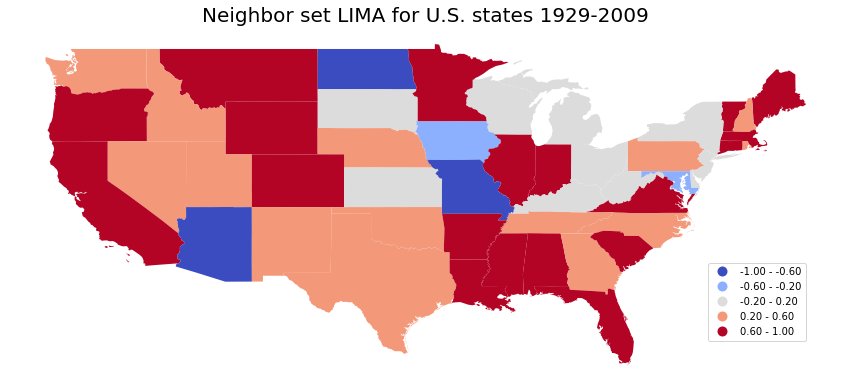

In [32]:
complete_table["tau_ln"] =tau_wr.tau_ln
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (15,8))
ln_map = complete_table.plot(ax=ax, column="tau_ln", cmap='coolwarm', scheme='equal_interval',legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.8, 0.15, 0.16, 0.2))
ln_map.set_title("Neighbor set LIMA for U.S. states 1929-2009",fontdict={"fontsize":20})
ax.set_axis_off()

Therefore, Arizona, North Dakota, and Missouri exchanged ranks with most of their neighbors over 1929-2009 while California, Virginia etc. barely exchanged ranks with their neighbors.

Let us see whether neighbor set LIMA statistics are siginificant for these "extreme" states:

In [33]:
tau_wr.tau_ln_pvalues

array([0.463, 0.256, 0.165, 0.101, 0.316, 0.336, 0.237, 0.614, 0.292,
       0.325, 0.33 , 0.675, 0.06 , 0.541, 0.412, 0.032, 0.594, 0.791,
       0.575, 0.049, 0.209, 0.48 , 0.488, 0.457, 0.605, 0.409, 0.259,
       0.018, 0.022, 0.405, 0.016, 0.25 , 0.001, 0.001, 0.045, 0.521,
       0.167, 0.363, 0.635, 0.478, 0.417, 0.247, 0.282, 0.423, 0.578,
       0.17 , 0.1  , 0.625])

In [34]:
sig_wr = tau_wr.tau_ln * (tau_wr.tau_ln_pvalues<0.05)
sig_wr

array([ 0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.09090909, -0.5       ,  0.        ,
        0.09090909,  0.        ,  0.63636364, -1.        , -1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

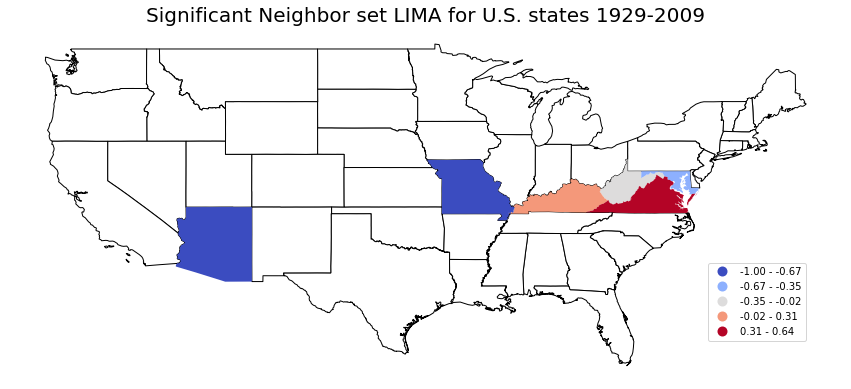

In [35]:
complete_table["sig_wr"] =sig_wr
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (15,8))
complete_table[complete_table["sig_wr"] == 0].plot(ax=ax, color='white',edgecolor='black')
sig_ln_map = complete_table[complete_table["sig_wr"] != 0].plot(ax=ax,column="sig_wr",cmap='coolwarm',scheme='equal_interval',legend=True)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.8, 0.15, 0.16, 0.2))
sig_ln_map.set_title("Significant Neighbor set LIMA for U.S. states 1929-2009",fontdict={"fontsize":20})
ax.set_axis_off()

Thus, Arizona and Missouri have significant and negative neighbor set LIMA values, and can be considered as hotspots of rank exchanges. This means that Arizona (or Missouri) tended to exchange ranks with its neighbors than with others over 1929-2009. On the contrary, Virgina has significant and large positive neighbor set LIMA value indicating that it tended to exchange ranks with its nonneighbors than with neighbors.

## References
* Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. 2010. “[Interregional Inequality Dynamics in Mexico](http://www.tandfonline.com/doi/abs/10.1080/17421772.2010.493955).” Spatial Economic Analysis 5 (3). Taylor & Francis: 277–98.
* Rey, Sergio J. 2014. “[Fast Algorithms for a Space-Time Concordance Measure](https://link.springer.com/article/10.1007/s00180-013-0461-2).” Computational Statistics 29 (3-4). Springer: 799–811.
* Rey, Sergio J. 2016. “[Space--Time Patterns of Rank Concordance: Local Indicators of Mobility Association with Application to Spatial Income Inequality Dynamics](http://www.tandfonline.com/doi/abs/10.1080/24694452.2016.1151336?journalCode=raag21).” Annals of the Association of American Geographers. Association of American Geographers 106 (4): 788–803.

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Spatial rank mobiity</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

[Wei Kang](https://spatial.ucr.edu/peopleKang.html) contributed to this notebook.